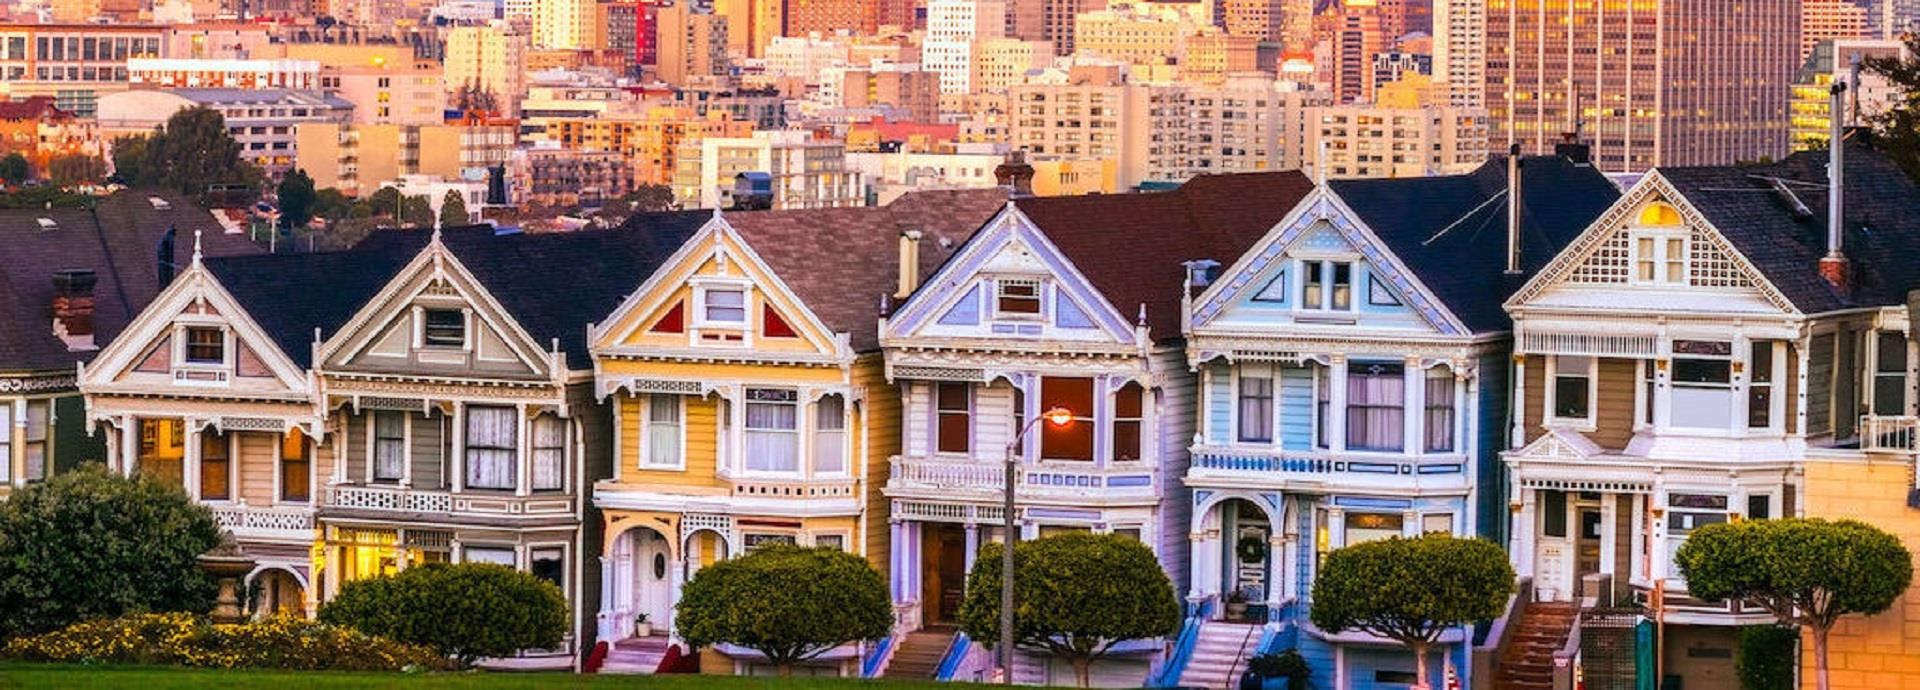

# Zillow Times Series Analysis 
Author: Jennifer Ha
***

## Overview 
This project analyzes New York City Airbnb listings data for the last 12 months (August 2020 - July 2021), which includes detailed information about the hosts and the listings. For the purpose of this project, the Airbnb marketing team would like to know which listings are valuable enough to be selected for their NYC promotion page in the coming winter. With the strong vaccination rate and eased Covid-19 regulation in the city, the team expects that more visitors would be looking for a place to stay in NYC moving forward. Since they cannot go over and compare each listing one by one, the team is looking for a prediction model that they can rely on to carefully select valuable listings that they can promote. They further anticipate to rely on the selected model from this analysis for their future promotions as well.

To help the Airbnb marketing team with accurately selecting the valuable listings in NYC, I'll be comparing classification models and further optimize the best performing model.

## Business Problem
The goal of this analysis is to predict whether a listing is valuable or not. The Airbnb marketing team has decided to consider top 25% listings as valuable, and have asked to calculate a weighted review scores rating to reward listings with more number of reviews and penalize listings with less number of reviews.

The team should be able to use the best model from this analysis to decide which listings are valuable and should be promoted to people who are searching for a place to stay when they visit New York City. We will focus on accuracy, precision, and ROC-AUC scores to determine which model performs the best. In this problem, accurately identifying a valuable listing is important as we cannot falsely advertise a listing with poor ratings.

## Data

This data represents median monthly housing sales prices for 265 zip codes over the period of April 1996 through April 2018 as reported by Zillow.

Each row represents a unique zip code. Each record contains location info and median housing sales prices for each month.

There are 14,723 rows and 272 variables:

RegionID: Unique index, 58196 through 753844
RegionName: Unique Zip Code, 1001 through 99901
City: City in which the zip code is located
State: State in which the zip code is located
Metro: Metropolitan Area in which the zip code is located
CountyName: County in which the zip code is located
SizeRank: Numerical rank of size of zip code, ranked 1 through 14723
1996-04 through 2018-04: refers to the median housing sales values for April 1996 through April 2018, that is 265 data points of monthly data for each zip code


In [1]:
# Import all libraries & packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error


In [2]:
# Import data into a dataframe and preview 
df = pd.read_csv('data/zillow_data.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
#Check for duplicates
df.RegionID.duplicated().sum()

0

In [4]:
# Keep CA state only
df_ca = df.loc[df['State']== 'CA'].reset_index()

# Drop unnecessary columns
df_ca.drop(['index', 'RegionID', 'SizeRank'], axis=1, inplace=True)

df_ca.info()
df_ca.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Columns: 270 entries, RegionName to 2018-04
dtypes: float64(219), int64(47), object(4)
memory usage: 2.5+ MB


,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,94109,San Francisco,CA,San Francisco,San Francisco,766000.0,771100.0,776500.0,781900.0,787300.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500
1,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,152500.0,152600.0,152600.0,152600.0,152600.0,...,579300,585700,590900,594700,598500,601300,602800,606100,612400,616200
2,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0,138300.0,137500.0,136600.0,135600.0,...,394900,398400,401600,405400,408600,410900,413700,417900,424300,430100
3,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,340600.0,341700.0,343000.0,344400.0,346100.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
4,94501,Alameda,CA,San Francisco,Alameda,222400.0,222300.0,222400.0,222600.0,223000.0,...,965100,975000,987800,1000000,1009900,1021000,1032400,1042000,1053000,1059700


In [5]:
# Rename "RegionName" to "Zipcode" 
df_ca = df_ca.rename(columns={'RegionName': 'ZipCode'})

df_ca.head()

,ZipCode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,94109,San Francisco,CA,San Francisco,San Francisco,766000.0,771100.0,776500.0,781900.0,787300.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500
1,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,152500.0,152600.0,152600.0,152600.0,152600.0,...,579300,585700,590900,594700,598500,601300,602800,606100,612400,616200
2,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0,138300.0,137500.0,136600.0,135600.0,...,394900,398400,401600,405400,408600,410900,413700,417900,424300,430100
3,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,340600.0,341700.0,343000.0,344400.0,346100.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
4,94501,Alameda,CA,San Francisco,Alameda,222400.0,222300.0,222400.0,222600.0,223000.0,...,965100,975000,987800,1000000,1009900,1021000,1032400,1042000,1053000,1059700


In [6]:
#Calculate average home value in the DataFrame
df_ca['yr_avg'] = df_ca.iloc[:,5:].mean(skipna=True, axis=1)


#Calculate historical return on investment
df_ca['ROI'] = (((df_ca['yr_avg'])/df_ca['1996-04'])).round(2)

#Calculate standard deviation of monthly values
df_ca['std'] = df_ca.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
df_ca['mean'] = df_ca.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variation
df_ca['CV'] = df_ca['std']/df_ca['mean']

#Show calculated values
df_ca[['ZipCode','yr_avg','std','mean','ROI','CV','CountyName']].head()

,ZipCode,yr_avg,std,mean,ROI,CV,CountyName
0,94109,2.395636e+06,821387.959699,2.395636e+06,3.13,0.342868,San Francisco
1,90250,3.654642e+05,138601.533036,3.654642e+05,2.40,0.379248,Los Angeles
2,94565,2.638743e+05,104006.852657,2.638743e+05,1.90,0.394153,Contra Costa
3,90046,1.041594e+06,431411.591252,1.041594e+06,3.06,0.414184,Los Angeles
4,94501,5.758958e+05,204420.930901,5.758958e+05,2.59,0.354962,Alameda


Our client mainly wants to focus on CA. let's drop the rest.

In [7]:
#Reshape from wide to long format
#Code from Project 4 Start Notebook
def melt_data(df):
    melted = pd.melt(df, 
                     id_vars=['ZipCode', 'City', 'State', 'Metro', 'CountyName','yr_avg','std','mean','ROI', 'CV'], 
                     var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [8]:
melted_df = melt_data(df_ca)
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318744 entries, 0 to 324359
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ZipCode     318744 non-null  int64         
 1   City        318744 non-null  object        
 2   State       318744 non-null  object        
 3   Metro       308142 non-null  object        
 4   CountyName  318744 non-null  object        
 5   yr_avg      318744 non-null  float64       
 6   std         318744 non-null  float64       
 7   mean        318744 non-null  float64       
 8   ROI         314820 non-null  float64       
 9   CV          318744 non-null  float64       
 10  Date        318744 non-null  datetime64[ns]
 11  value       318744 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(4)
memory usage: 31.6+ MB


In [9]:
#Convert data type to object for ZipCode column
melted_df['ZipCode'] = melted_df['ZipCode'].astype(str)

# Make sure the data type of the 'Date' column is datetime
melted_df['Date'] = pd.to_datetime(melted_df['Date'], format='%m/%y')

# Set the 'Date' column as index
melted_df.set_index('Date', inplace=True)

melted_df.head()

,ZipCode,City,State,Metro,CountyName,yr_avg,std,mean,ROI,CV,value
Date,,,,,,,,,,,
1996-04-01,94109,San Francisco,CA,San Francisco,San Francisco,2.395636e+06,821387.959699,2.395636e+06,3.13,0.342868,766000.0
1996-04-01,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,3.654642e+05,138601.533036,3.654642e+05,2.40,0.379248,152500.0
1996-04-01,94565,Pittsburg,CA,San Francisco,Contra Costa,2.638743e+05,104006.852657,2.638743e+05,1.90,0.394153,139200.0
1996-04-01,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1.041594e+06,431411.591252,1.041594e+06,3.06,0.414184,340600.0
1996-04-01,94501,Alameda,CA,San Francisco,Alameda,5.758958e+05,204420.930901,5.758958e+05,2.59,0.354962,222400.0


In [10]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 318744 entries, 1996-04-01 to 2018-04-01
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ZipCode     318744 non-null  object 
 1   City        318744 non-null  object 
 2   State       318744 non-null  object 
 3   Metro       308142 non-null  object 
 4   CountyName  318744 non-null  object 
 5   yr_avg      318744 non-null  float64
 6   std         318744 non-null  float64
 7   mean        318744 non-null  float64
 8   ROI         314820 non-null  float64
 9   CV          318744 non-null  float64
 10  value       318744 non-null  float64
dtypes: float64(6), object(5)
memory usage: 29.2+ MB


While there was a Housing Bubble and Great Despression
[Great Recession](https://en.wikipedia.org/wiki/Great_Recession)


For this dataset, we will only include data from CA. Because of the housing market crash, any modelling that uses only recent years may be misleading. We will use every value from 1996 to 2018 so we can have the most accurate picture of home values in CA through the years.

## Exploratory Data Analysis (EDA)


On this step we will be creating visualizations to get a better idea of what we are working with and also to understand the trends of the values in our data.
Here we get a good idea of the average home value per County name.

In [11]:
print('Average CA home value' ,round(melted_df['value'].mean()))

Average CA home value 457429


average home value by month and year

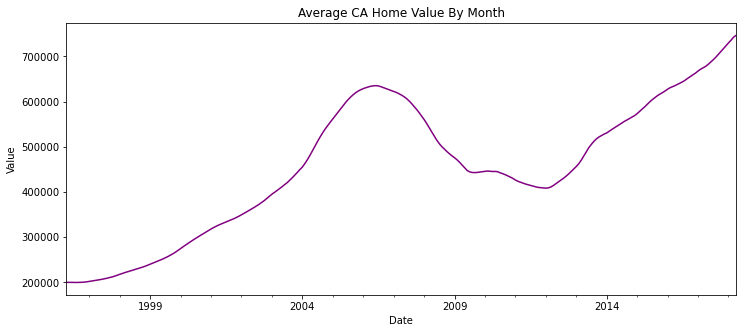

In [12]:
# Resample data by month
month_data = melted_df['value'].resample('MS').mean()
month_data = month_data.fillna(month_data.bfill())
month_data.plot(figsize=(12,5), color='purple')
plt.title('Average CA Home Value By Month')
plt.ylabel('Value')
plt.show()

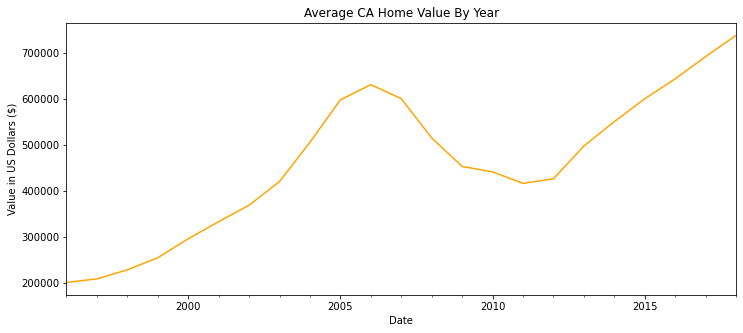

In [13]:
# Resample data by month
yr_data = melted_df['value'].resample('A').mean()
yr_data.plot.line(figsize=(12,5), color='orange')
plt.title('Average CA Home Value By Year')
plt.ylabel('Value in US Dollars ($)')
plt.show()

### Top 10 Metro & County (mean value)

In [14]:
metro = melted_df.groupby('Metro')
metro = metro.value.mean()
metro = metro.sort_values(ascending=False).head(10)

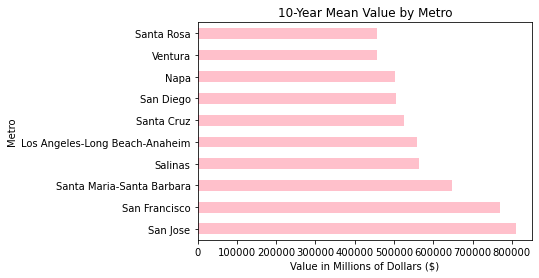

In [15]:
metro.plot.barh(color='pink')
plt.title('10-Year Mean Value by Metro')
plt.xlabel('Value in Millions of Dollars ($)')
plt.show()

In [16]:
county = melted_df.groupby('CountyName')
county = county.value.mean()
county = county.sort_values(ascending=False).head(10)

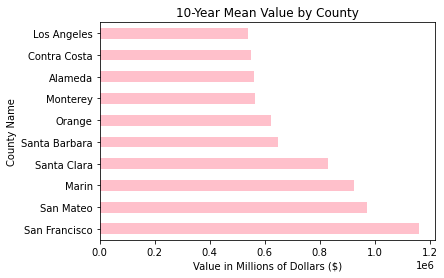

In [17]:
county.plot.barh(color='pink')
plt.title('10-Year Mean Value by County')
plt.xlabel('Value in Millions of Dollars ($)')
plt.ylabel('County Name')
plt.show()

### Top 10 Zipcode ( mean ROI)

For calculating ROI, 
get yr_avg first because we are not measuring how much the home value has increased since July 2009.

In finance, the coefficient of variation allows investors to determine how much volatility, or risk, is assumed in comparison to the amount of return expected from investments. Ideally, if the coefficient of variation formula should result in a lower ratio of the standard deviation to mean return, then the better the risk-return trade-off. Therefore, in these next steps we are going to filter the data some more by calculating the CV value and only selecting values with in the company's risk factor (assume 70 percentile).

In finance, the coefficient of variation allows investors to determine how much volatility, or risk, is assumed in comparison to the amount of return expected from investments.
The lower the ratio of the standard deviation to mean return, the better risk-return trade-off.



In [18]:
#find out the top 10 couties with highest ROI (with risk factor)
top10_r = df_ca.groupby('CountyName', group_keys=False).sum()['ROI']
top10_r.sort_values(ascending=False)[:10]

CountyName
Los Angeles       629.27
San Diego         203.66
Orange            202.33
Santa Clara       131.53
Riverside         117.85
San Bernardino    109.53
Alameda           103.62
Sacramento         89.51
Fresno             63.45
Contra Costa       62.28
Name: ROI, dtype: float64

In [19]:
#Get descriptive statistics of coefficients of variance
print(df_ca.CV.describe())

#Get the 10 counties with highest ROIs within the firms risk profile. top 30%
thresh_cv = df_ca.CV.quantile(.3)
print(f'\nCV upper threshold: {thresh_cv}')
top10_nr = df_ca[df_ca['CV']<=thresh_cv].sort_values('ROI', axis=0, ascending=False)

#find out the top 10 couties with highest ROI (without risk factor)
county_grouped = top10_nr.groupby('CountyName').sum()['ROI']
county_grouped.sort_values(ascending=False)[:10]

count    1224.000000
mean        0.343098
std         0.057060
min         0.044380
25%         0.312025
50%         0.340961
75%         0.375903
max         0.553350
Name: CV, dtype: float64

CV upper threshold: 0.31696293742242887


CountyName
San Diego      80.53
Orange         43.97
Sonoma         41.04
Placer         35.54
Marin          28.78
Fresno         28.33
Tulare         24.73
Santa Cruz     23.23
Los Angeles    22.43
Riverside      21.95
Name: ROI, dtype: float64

In [20]:
top10_county = list(county_grouped.sort_values(ascending=False)[:10].index)
top10_county

['San Diego',
 'Orange',
 'Sonoma',
 'Placer',
 'Marin',
 'Fresno',
 'Tulare',
 'Santa Cruz',
 'Los Angeles',
 'Riverside']

In [21]:
#Keep top 10 counties only
df_top10 = top10_nr.loc[top10_nr['CountyName'].isin(top10_county)]

In [22]:
#Check how many zip code are in each county
df_top10['CountyName'].value_counts()

San Diego      37
Fresno         20
Orange         19
Sonoma         19
Placer         18
Tulare         16
Los Angeles    14
Marin          13
Riverside      12
Santa Cruz     10
Name: CountyName, dtype: int64

In [23]:
# Highest ROI in each county
df_top10.groupby('CountyName').max()['ROI']

CountyName
Fresno         1.87
Los Angeles    2.28
Marin          2.50
Orange         2.45
Placer         2.72
Riverside      2.02
San Diego      2.58
Santa Cruz     2.52
Sonoma         2.36
Tulare         1.76
Name: ROI, dtype: float64

In [24]:
#Get city and state names for each zip code
ziplist = []
roi_top10 = {}

for i in top10_county:
    City = df_top10[df_top10['CountyName']==i].City.values[0]
    Metro = df_top10[df_top10['CountyName']==i].Metro.values[0]
    ZipCode = df_top10[df_top10['CountyName']==i].ZipCode.values[0]
    ROI = (df_top10[df_top10['CountyName']==i].max()['ROI'])
    
    ziplist.append(ZipCode)
    roi_top10[i] = ROI
    print(f'County: {i}, ROI: {ROI} \nCity: {City}, Zipcode: {ZipCode}, Metro: {Metro}\n')

County: San Diego, ROI: 2.58 
City: San Diego, Zipcode: 92106, Metro: San Diego

County: Orange, ROI: 2.45 
City: Mission Viejo, Zipcode: 92692, Metro: Los Angeles-Long Beach-Anaheim

County: Sonoma, ROI: 2.36 
City: Occidental, Zipcode: 95465, Metro: Santa Rosa

County: Placer, ROI: 2.72 
City: Tahoe City, Zipcode: 96146, Metro: Sacramento

County: Marin, ROI: 2.5 
City: Tiburon, Zipcode: 94920, Metro: San Francisco

County: Fresno, ROI: 1.87 
City: Fowler, Zipcode: 93625, Metro: Fresno

County: Tulare, ROI: 1.76 
City: Visalia, Zipcode: 93291, Metro: Visalia

County: Santa Cruz, ROI: 2.52 
City: Santa Cruz, Zipcode: 95060, Metro: Santa Cruz

County: Los Angeles, ROI: 2.28 
City: Torrance, Zipcode: 90505, Metro: Los Angeles-Long Beach-Anaheim

County: Riverside, ROI: 2.02 
City: Indio, Zipcode: 92203, Metro: Riverside



In [25]:
x = dict(sorted(roi_top10.items(), key=lambda item: item[1])).keys()

In [26]:
y = dict(sorted(roi_top10.items(), key=lambda item: item[1])).values()

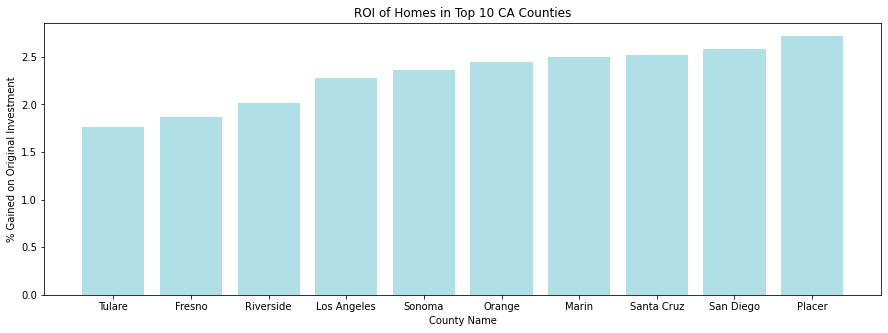

In [27]:
plt.figure(figsize=(15,5))
plt.bar(x, y, color='powderblue')
plt.title('ROI of Homes in Top 10 CA Counties')
plt.xlabel('County Name')
plt.ylabel('% Gained on Original Investment')
plt.show()

In [28]:
def visualize_time_series(df, name):
    """Plot time series. Plot annual breakouts for years with all 12 values."""
    df.plot(figsize = (12,4))
    plt.title(name)
    plt.xlabel('Year')
    plt.ylabel('Median House Price')
    ;
    
    # Use pandas grouper to group values using annual frequency
    year_groups = df.groupby(pd.Grouper(freq ='A'))

    # Create a new DataFrame and store yearly values in columns 
    df_annual = pd.DataFrame()

    # print(list(year_groups))
    for yr, group in year_groups:
        if len(group) == 12: # Can only use full years of data
            df_annual[yr.year] = group.values.ravel()
    
    # Plot the yearly groups as subplots
    df_annual.plot(figsize = (13,20), subplots=True, legend=True)
    plt.savefig('Images/annual_breakout.png');

    # Plot overlapping yearly groups 
    df_annual.plot(figsize = (15,10), subplots=False, legend=True)
    plt.savefig('Images/annual_overlap.png');

The home sale values have turned up to show that our 10 counties have had an ROI gain of at least 150% of their original value from 1996. With Placer, Orange county, San Luis Obispo and San Diego making it to above 250%.

In [29]:
#save data on each of the 10 zip codes 
zip_92106 = melted_df[melted_df['ZipCode']=='92106']
zip_92692 = melted_df[melted_df['ZipCode']=='92692']
zip_95465 = melted_df[melted_df['ZipCode']=='95465']
zip_96146 = melted_df[melted_df['ZipCode']=='96146']
zip_94920 = melted_df[melted_df['ZipCode']=='94920']
zip_93625 = melted_df[melted_df['ZipCode']=='93625']
zip_93291 = melted_df[melted_df['ZipCode']=='93291']
zip_95060 = melted_df[melted_df['ZipCode']=='95060']
zip_90505 = melted_df[melted_df['ZipCode']=='90505']
zip_92203 = melted_df[melted_df['ZipCode']=='92203']


In [30]:
#Create a dataframe for the top10 zipcodes
zip_df = pd.DataFrame()
zip_df = zip_df.append(zip_92106)
zip_df = zip_df.append(zip_92692)
zip_df = zip_df.append(zip_95465)
zip_df = zip_df.append(zip_96146)
zip_df = zip_df.append(zip_94920)
zip_df = zip_df.append(zip_93625)
zip_df = zip_df.append(zip_93291)
zip_df = zip_df.append(zip_95060)
zip_df = zip_df.append(zip_90505)
zip_df = zip_df.append(zip_92203)
zip_df.info()
zip_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2650 entries, 1996-04-01 to 2018-04-01
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ZipCode     2650 non-null   object 
 1   City        2650 non-null   object 
 2   State       2650 non-null   object 
 3   Metro       2650 non-null   object 
 4   CountyName  2650 non-null   object 
 5   yr_avg      2650 non-null   float64
 6   std         2650 non-null   float64
 7   mean        2650 non-null   float64
 8   ROI         2650 non-null   float64
 9   CV          2650 non-null   float64
 10  value       2650 non-null   float64
dtypes: float64(6), object(5)
memory usage: 248.4+ KB


,ZipCode,City,State,Metro,CountyName,yr_avg,std,mean,ROI,CV,value
Date,,,,,,,,,,,
1996-04-01,92106,San Diego,CA,San Diego,San Diego,739070.566038,226311.857026,739070.566038,2.58,0.306211,286100.0
1996-05-01,92106,San Diego,CA,San Diego,San Diego,739070.566038,226311.857026,739070.566038,2.58,0.306211,285300.0
1996-06-01,92106,San Diego,CA,San Diego,San Diego,739070.566038,226311.857026,739070.566038,2.58,0.306211,284600.0
1996-07-01,92106,San Diego,CA,San Diego,San Diego,739070.566038,226311.857026,739070.566038,2.58,0.306211,284100.0
1996-08-01,92106,San Diego,CA,San Diego,San Diego,739070.566038,226311.857026,739070.566038,2.58,0.306211,283900.0


In [31]:
zip_ts = []
for zc in zip_df.ZipCode.unique():
    #Create separate dataframes for each zipcode with a monthly frequency.
    top10_df = zip_df[zip_df['ZipCode']==zc].asfreq('MS')
    zip_ts.append(top10_df)

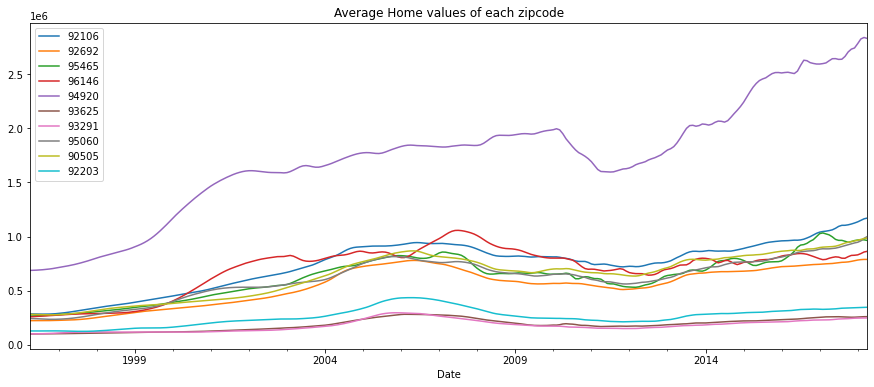

In [32]:
for i in range(10):
    zip_ts[i].value.plot(label=zip_ts[i].ZipCode[0],figsize=(15,6))
    plt.title('Average Home values of each zipcode')
    plt.legend()

## Improving Stationarity

While the trend in most zipcodes seem to be stationary, there are still evident fluctuation across all with 94920 showing the most.

In [33]:
#Calculate monthly returns in new column 'ret' for each zipcode.
for zc in range(len(zip_ts)):
    zip_ts[zc]['ret']=np.nan*len(zip_ts[zc])
    for i in range(len(zip_ts[zc])-1):
        zip_ts[zc]['ret'][i+1]= (zip_ts[zc].value.iloc[i+1] / zip_ts[zc].value.iloc[i]) - 1

In [34]:
for i in range(10):
    results = adfuller(zip_ts[i].ret.dropna())
    print(f'ADFuller test p-value for zipcode: {zip_ts[i].ZipCode[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 92106
p-value: 0.4211667092120997
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 92692
p-value: 0.19963761373283812
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 95465
p-value: 0.17351431550229068
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 96146
p-value: 0.14738514793239887
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 94920
p-value: 0.18078903779046623
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 93625
p-value: 0.42983191819243854
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 93291
p-value: 0.12283275076581435
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 95060
p-value: 0.04334138886831742
Reject the nul

우리가 예상했던 것처럼 거의 다 not stationary

#### P-value Check - Differencing Values for Each Zipcode

In [35]:
zip_df2 = pd.DataFrame()

zip_92106['otm'] = zip_92106.value.diff()
zip_92106['ret'] = zip_92106['otm']/zip_92106['value']
zip_92106 = zip_92106.dropna()
zip_df2 = zip_df2.append(zip_92106)


zip_92692['otm'] = zip_92692.value.diff()
zip_92692['ret'] = zip_92692['otm']/zip_92692['value']
zip_92692 = zip_92692.dropna()
zip_df2 = zip_df2.append(zip_92692)

zip_95465['otm'] = zip_95465.value.diff()
zip_95465['ret'] = zip_95465['otm']/zip_95465['value']
zip_95465 = zip_95465.dropna()
zip_df2 = zip_df2.append(zip_95465)
                        
zip_96146['otm'] = zip_96146.value.diff()
zip_96146['ret'] = zip_96146['otm']/zip_96146['value']
zip_96146 = zip_96146.dropna()
zip_df2 = zip_df2.append(zip_96146)
                        
zip_94920['otm'] = zip_94920.value.diff()
zip_94920['ret'] = zip_94920['otm']/zip_94920['value']
zip_94920 = zip_94920.dropna()
zip_df2 = zip_df2.append(zip_94920)
                        
zip_93625['otm'] = zip_93625.value.diff()
zip_93625['ret'] = zip_93625['otm']/zip_93625['value']
zip_93625 = zip_93625.dropna()
zip_df2 = zip_df2.append(zip_93625)
                        
zip_93291['otm'] = zip_93291.value.diff()
zip_93291['ret'] = zip_93291['otm']/zip_93291['value']
zip_93291 = zip_93291.dropna()
zip_df2 = zip_df2.append(zip_93291)
                        
zip_95060['otm'] = zip_95060.value.diff()
zip_95060['ret'] = zip_95060['otm']/zip_95060['value']
zip_95060 = zip_95060.dropna()
zip_df2 = zip_df2.append(zip_95060)
                        
zip_90505['otm'] = zip_90505.value.diff()
zip_90505['ret'] = zip_90505['otm']/zip_90505['value']
zip_90505 = zip_90505.dropna()
zip_df2 = zip_df2.append(zip_90505)
                        
zip_92203['otm'] = zip_92203.value.diff()
zip_92203['ret'] = zip_92203['otm']/zip_92203['value']
zip_92203 = zip_92203.dropna()
zip_df2 = zip_df2.append(zip_92203)

In [36]:
df_top10 = pd.concat([zip_92106,zip_92692,zip_95465,zip_96146,zip_94920,zip_93625,zip_93291,zip_95060,zip_90505,zip_92203])

df_top10.info()
df_top10.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2640 entries, 1996-05-01 to 2018-04-01
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ZipCode     2640 non-null   object 
 1   City        2640 non-null   object 
 2   State       2640 non-null   object 
 3   Metro       2640 non-null   object 
 4   CountyName  2640 non-null   object 
 5   yr_avg      2640 non-null   float64
 6   std         2640 non-null   float64
 7   mean        2640 non-null   float64
 8   ROI         2640 non-null   float64
 9   CV          2640 non-null   float64
 10  value       2640 non-null   float64
 11  otm         2640 non-null   float64
 12  ret         2640 non-null   float64
dtypes: float64(8), object(5)
memory usage: 288.8+ KB


,ZipCode,City,State,Metro,CountyName,yr_avg,std,mean,ROI,CV,value,otm,ret
Date,,,,,,,,,,,,,
1996-05-01,92106,San Diego,CA,San Diego,San Diego,739070.566038,226311.857026,739070.566038,2.58,0.306211,285300.0,-800.0,-0.002804
1996-06-01,92106,San Diego,CA,San Diego,San Diego,739070.566038,226311.857026,739070.566038,2.58,0.306211,284600.0,-700.0,-0.002460
1996-07-01,92106,San Diego,CA,San Diego,San Diego,739070.566038,226311.857026,739070.566038,2.58,0.306211,284100.0,-500.0,-0.001760
1996-08-01,92106,San Diego,CA,San Diego,San Diego,739070.566038,226311.857026,739070.566038,2.58,0.306211,283900.0,-200.0,-0.000704
1996-09-01,92106,San Diego,CA,San Diego,San Diego,739070.566038,226311.857026,739070.566038,2.58,0.306211,284000.0,100.0,0.000352


In [37]:
zip_ts2 = []
for zc in zip_df2.ZipCode.unique():
    #Create separate dataframes for each zipcode with a monthly frequency.
    top10_df2 = zip_df2[zip_df2['ZipCode']==zc].asfreq('MS')
    zip_ts2.append(top10_df2)

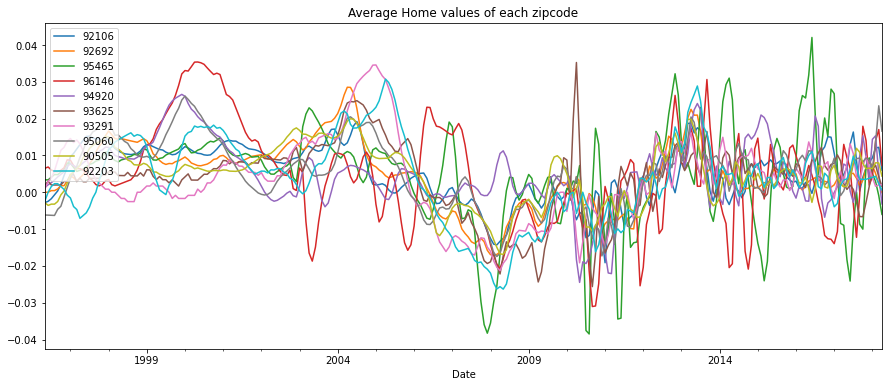

In [38]:
for i in range(10):
    zip_ts2[i].ret.plot(label=zip_ts2[i].ZipCode[0],figsize=(15,6))
    plt.title('Average Home values of each zipcode')
    plt.legend(loc='upper left')

In [39]:
for i in range(10):
    #Perform adfuller test and drop NaN values created when calculating monthly returns.
    results = adfuller(zip_ts2[i].ret.diff().dropna()) #differencing by 12 month for stationarity
    print(f'ADFuller test p-value for zipcode: {zip_ts2[i].ZipCode[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 92106
p-value: 2.916726157916125e-05
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 92692
p-value: 6.457531842834566e-05
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 95465
p-value: 1.0093221592553517e-06
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 96146
p-value: 8.142998058733607e-07
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 94920
p-value: 5.001897775973092e-07
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 93625
p-value: 4.234016795611619e-11
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 93291
p-value: 0.0003014881506881958
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 95060
p-value: 1.8338110306140808e-05
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipc

## Building Initial Model

In [ ]:
zip_ts

In [ ]:
# The top 10 list we will be analyzing 
ziplist = ['92101', '91754', '92866', '92860', '96141', '95441', '93405',
           '95818', '93003', '94546']

In [ ]:
ts = {}
for zc in ziplist:
    temp_df = zip_ts.groupby('ZipCode').get_group(zc).sort_index()['value']
    ts[zc] = temp_df

In [ ]:
ts_df = pd.DataFrame(ts)
ts_df.head()

In [ ]:
zip_1 = ziplist[0]

In [ ]:
ts_zip1 = ts_df[zip_1].copy()
ax = ts_zip1.plot()
ax.legend()
plt.show()

We want to build a time series model to predict the future ROI for the 30 zipcodes across our three datasets. But first, we will select one specific zipcode to build our timeseries model on. Then, we'll implement a similar workflow on teh other zipcodes in our datasets to identify which zipcodes have the highest ROI.

To accomplish this, I will take the zipcode with the highest ROI in the mid-size city dataset.

Recommendation:
1. potentially layering in population data
2. include more recent data